In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score, accuracy_score
from sklearn.feature_selection import SelectFromModel
from imblearn.over_sampling import SMOTE
import warnings
warnings.filterwarnings('ignore')

In [21]:
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

In [22]:
df = pd.read_csv('imputed_original_16_single_best.csv')
# df = pd.read_csv('imputed_original_20_ensemble.csv')
target_col = 're.admission.within.6.months'

X = df.drop(columns=[target_col])
y = df[target_col]


In [23]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y
)

In [24]:
smote = SMOTE(
    random_state=RANDOM_STATE, 
    k_neighbors=7,        # Increased from 5
    sampling_strategy='auto'
)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)


In [25]:
rf_model_initial = RandomForestClassifier(
    n_estimators=200,    # Increased from 150
    max_depth=12,        # Reduced from 15 to prevent overfitting
    min_samples_split=8,  # Increased from 5
    min_samples_leaf=4,   # Increased from 2
    class_weight='balanced', # Add class weights
    random_state=RANDOM_STATE,
    n_jobs=-1
)

In [26]:
rf_model_initial.fit(X_train_smote, y_train_smote)

RandomForestClassifier(class_weight='balanced', max_depth=12,
                       min_samples_leaf=4, min_samples_split=8,
                       n_estimators=200, n_jobs=-1, random_state=42)

In [27]:
selector = SelectFromModel(rf_model_initial, prefit=True, threshold='1.25*mean')
X_train_selected = selector.transform(X_train_smote)
X_test_selected = selector.transform(X_test)


In [28]:
rf_model_final = RandomForestClassifier(
    n_estimators=150,
    max_depth=15,
    min_samples_split=5,
    min_samples_leaf=2,
    random_state=RANDOM_STATE,
    n_jobs=-1
)


In [29]:
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
cv_scores = cross_val_score(rf_model_final, X_train_selected, y_train_smote, cv=kfold, scoring='f1')
print(f"Mean CV F1 score: {cv_scores.mean():.4f} (±{cv_scores.std():.4f})")

Mean CV F1 score: 0.6307 (±0.0248)


In [30]:
rf_model_final.fit(X_train_selected, y_train_smote)
y_pred = rf_model_final.predict(X_test_selected)

In [31]:
metrics = {
    "Accuracy": accuracy_score(y_test, y_pred),
    "Precision": precision_score(y_test, y_pred),
    "Recall": recall_score(y_test, y_pred),
    "F1 Score": f1_score(y_test, y_pred)
}

In [32]:
print("\nModel Performance Metrics:")
print("-" * 25)
for metric, value in metrics.items():
    print(f"{metric}: {value:.4f}")


Model Performance Metrics:
-------------------------
Accuracy: 0.5920
Precision: 0.4724
Recall: 0.4968
F1 Score: 0.4843


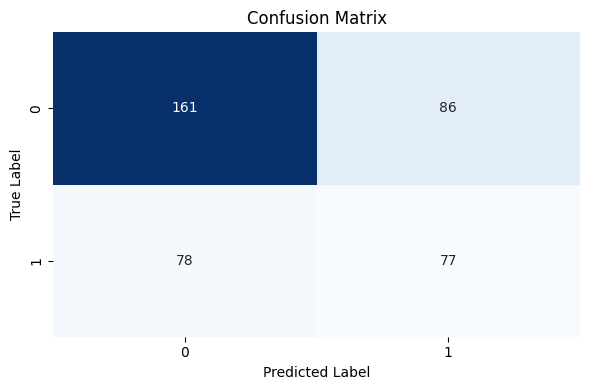

In [33]:
plt.figure(figsize=(6, 4))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()

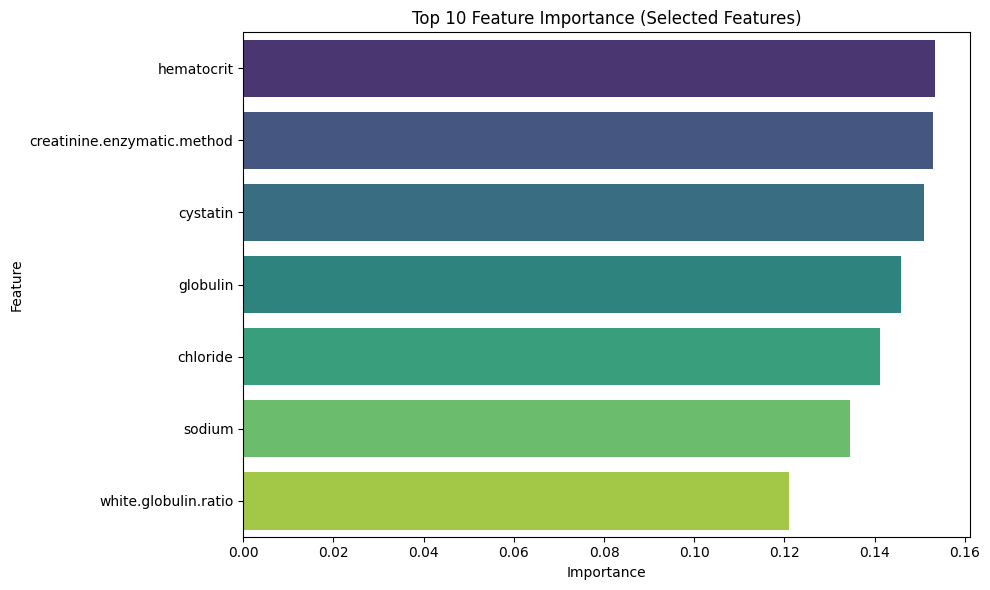

In [34]:
selected_features_mask = selector.get_support()
selected_features = X.columns[selected_features_mask]
feature_importance = pd.DataFrame({
    'Feature': selected_features,
    'Importance': rf_model_final.feature_importances_
}).sort_values(by='Importance', ascending=False)

# Plot top 10 features
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance.head(10), palette='viridis')
plt.title('Top 10 Feature Importance (Selected Features)')
plt.tight_layout()
plt.show()

In [35]:
paper_f1_score = 0.4799
current_f1 = metrics["F1 Score"]
print(f"\nF1 Score Comparison:")
print(f"Paper F1: {paper_f1_score:.4f} | Our F1: {current_f1:.4f} | Diff: {current_f1 - paper_f1_score:.4f}")

# Print selected features
print("\nSelected Features:")
print("-" * 25)
print("\n".join(selected_features))


F1 Score Comparison:
Paper F1: 0.4799 | Our F1: 0.4843 | Diff: 0.0044

Selected Features:
-------------------------
globulin
hematocrit
white.globulin.ratio
creatinine.enzymatic.method
cystatin
sodium
chloride
